In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from typing import List
import itertools

plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['axes.grid'] = False

In [10]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df = df[5::6]
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [11]:
n = len(df)
train_data = df[:int(n*0.9)]
test_data = df[int(n*0.9):]

In [14]:
items_to_upload = []
for row in train_data.values.tolist():
    key = str(row[0])
    values = row[1:]
    items_to_upload.append((key, values))

In [16]:
query_dates = []
query_data = []
for row in test_data.values.tolist():
    query_dates.append(str(row[0]))
    query_data.append(row[1:])

In [19]:
from qdrant_client import QdrantClient
from qdrant_client.http import models

In [56]:
client = QdrantClient(
    os.getenv("QDRANT_HOST"),
    api_key=os.getenv("QDRANT_API_KEY")
)

client.create_collection(
    collection_name="timeseries",
    vectors_config=models.VectorParams(
        size=14,
        distance='Cosine'
    )
)

True

In [57]:
from qdrant_client.http.models import PointStruct

for i, (key, values) in enumerate(items_to_upload):
    payload = [
        PointStruct(id=i, vector=values, payload={"key": key})
    ]
    client.upsert(collection_name="timeseries", points=payload)

In [58]:
all_results = []
for xq in tqdm(query_data):
    res = client.search(collection_name="timeseries", query_vector=xq, limit=1)
    all_results.append(res)

  0%|          | 0/7010 [00:00<?, ?it/s]

In [123]:
def get_predictions(feature: str) -> (List, List):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, all_results):
        similar_date = [res.payload['key'] for res in qr][0]
        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1) 
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = df.loc[df['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = df.loc[df['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values

In [124]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {root_mean_squared_error(true_values, predicted_values)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

Analyzing predictions for p (mbar)


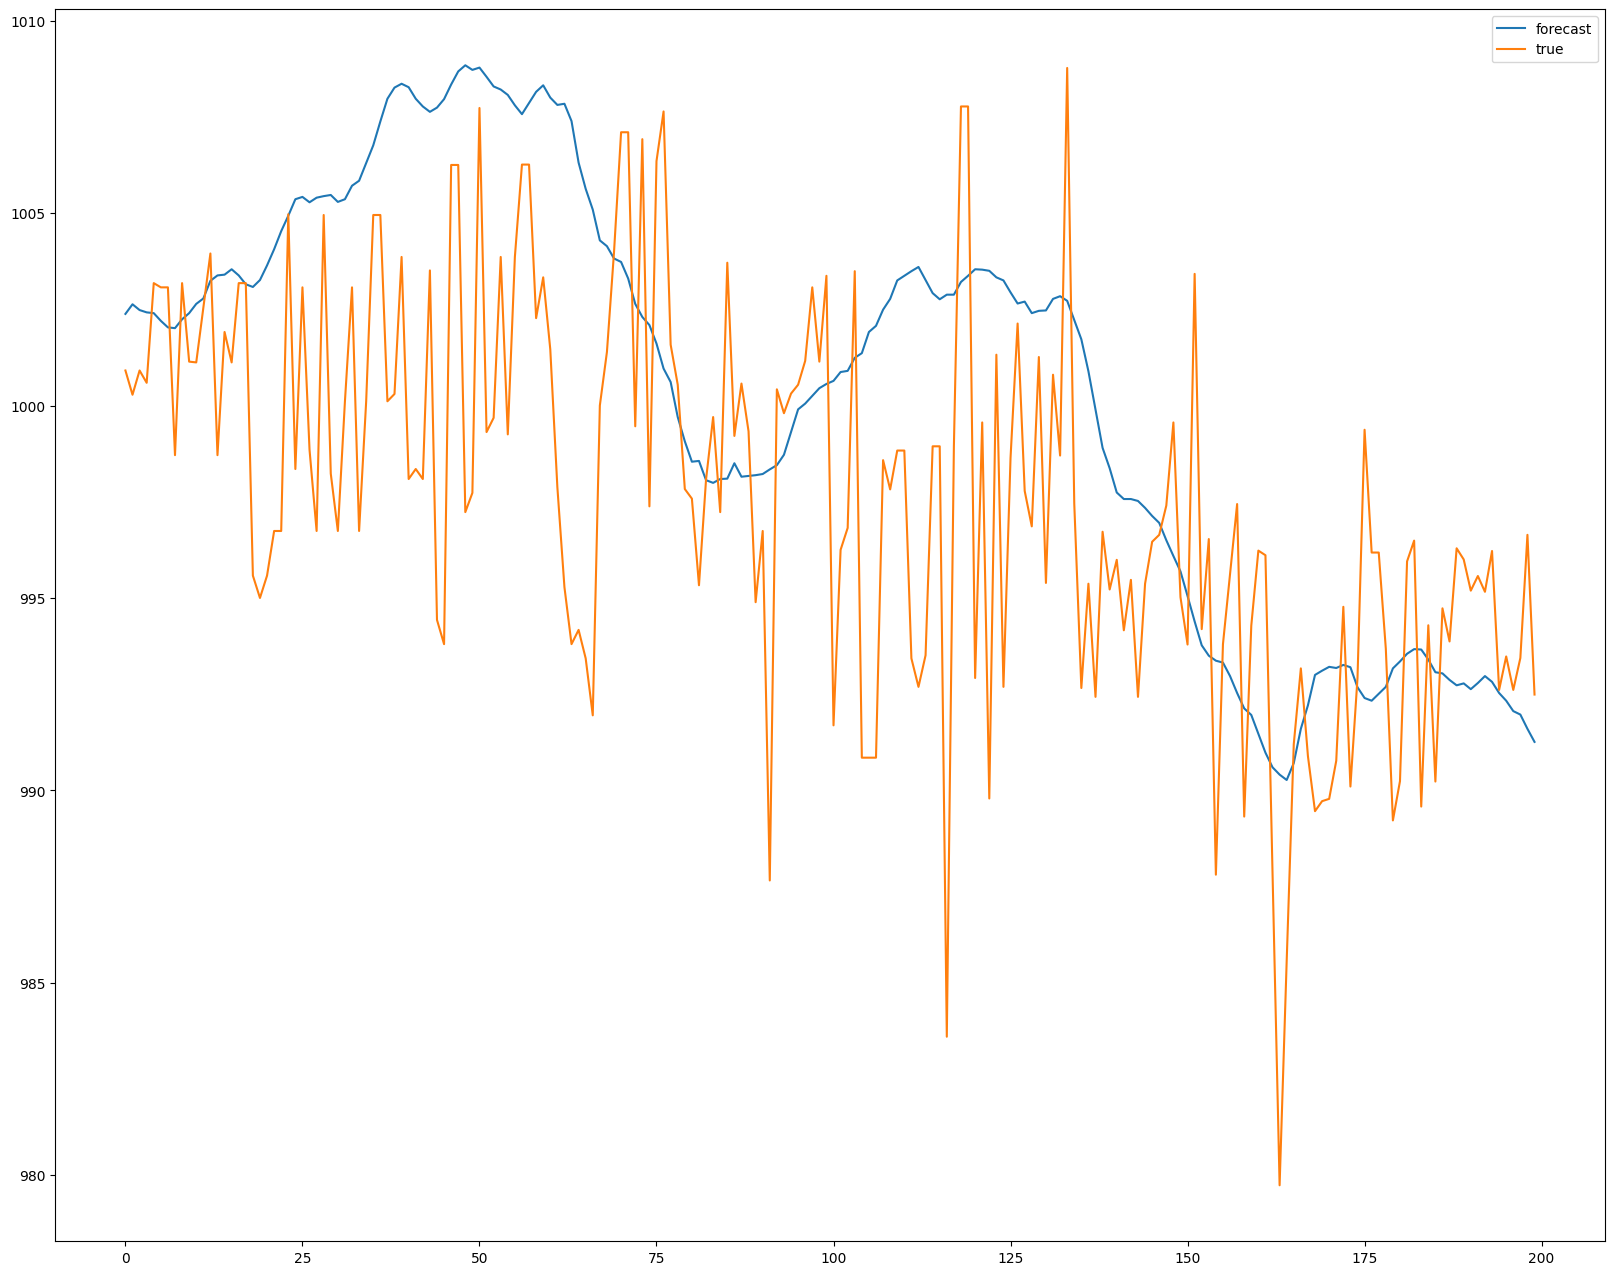

MSE: 22.139340773512203
RMSE: 4.705246090643103
MAE: 3.682269159412017
Analyzing predictions for T (degC)


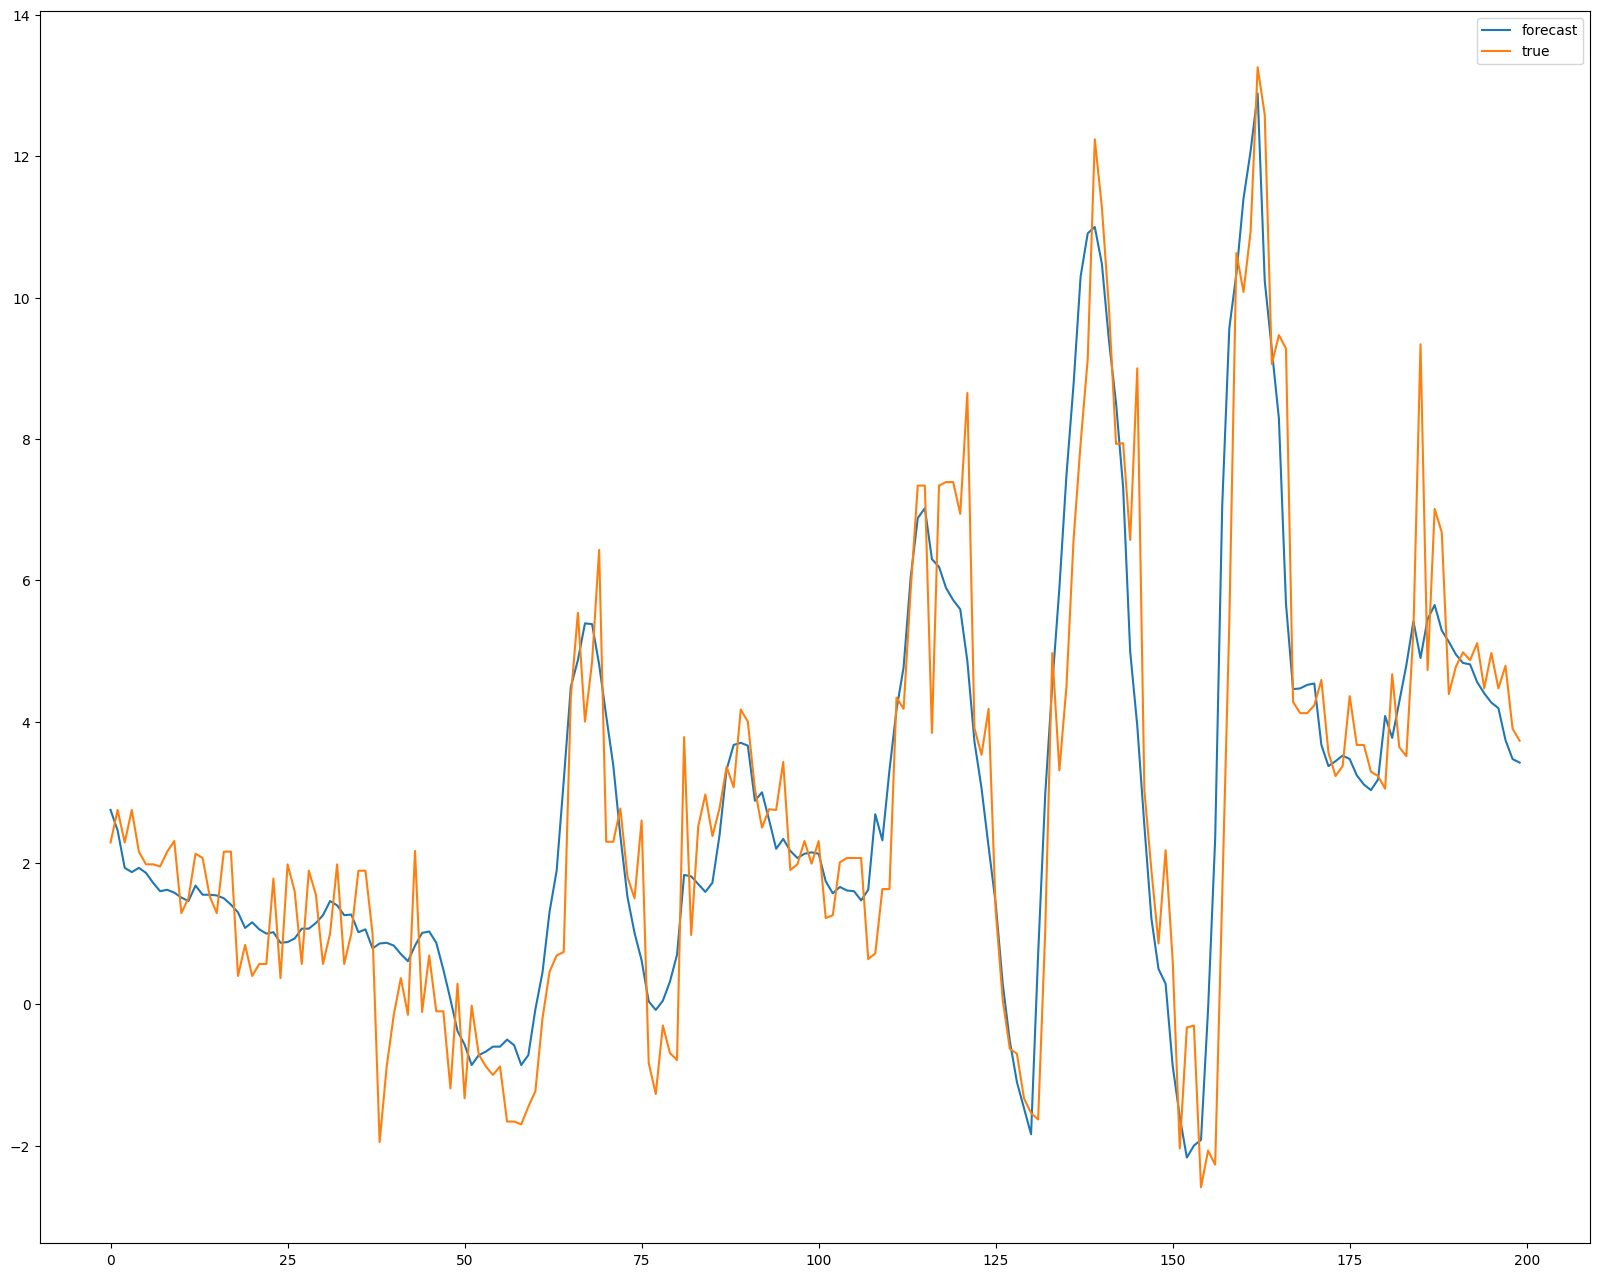

MSE: 2.127534065934066
RMSE: 1.4586068921865363
MAE: 1.081193092621664
Analyzing predictions for Tpot (K)


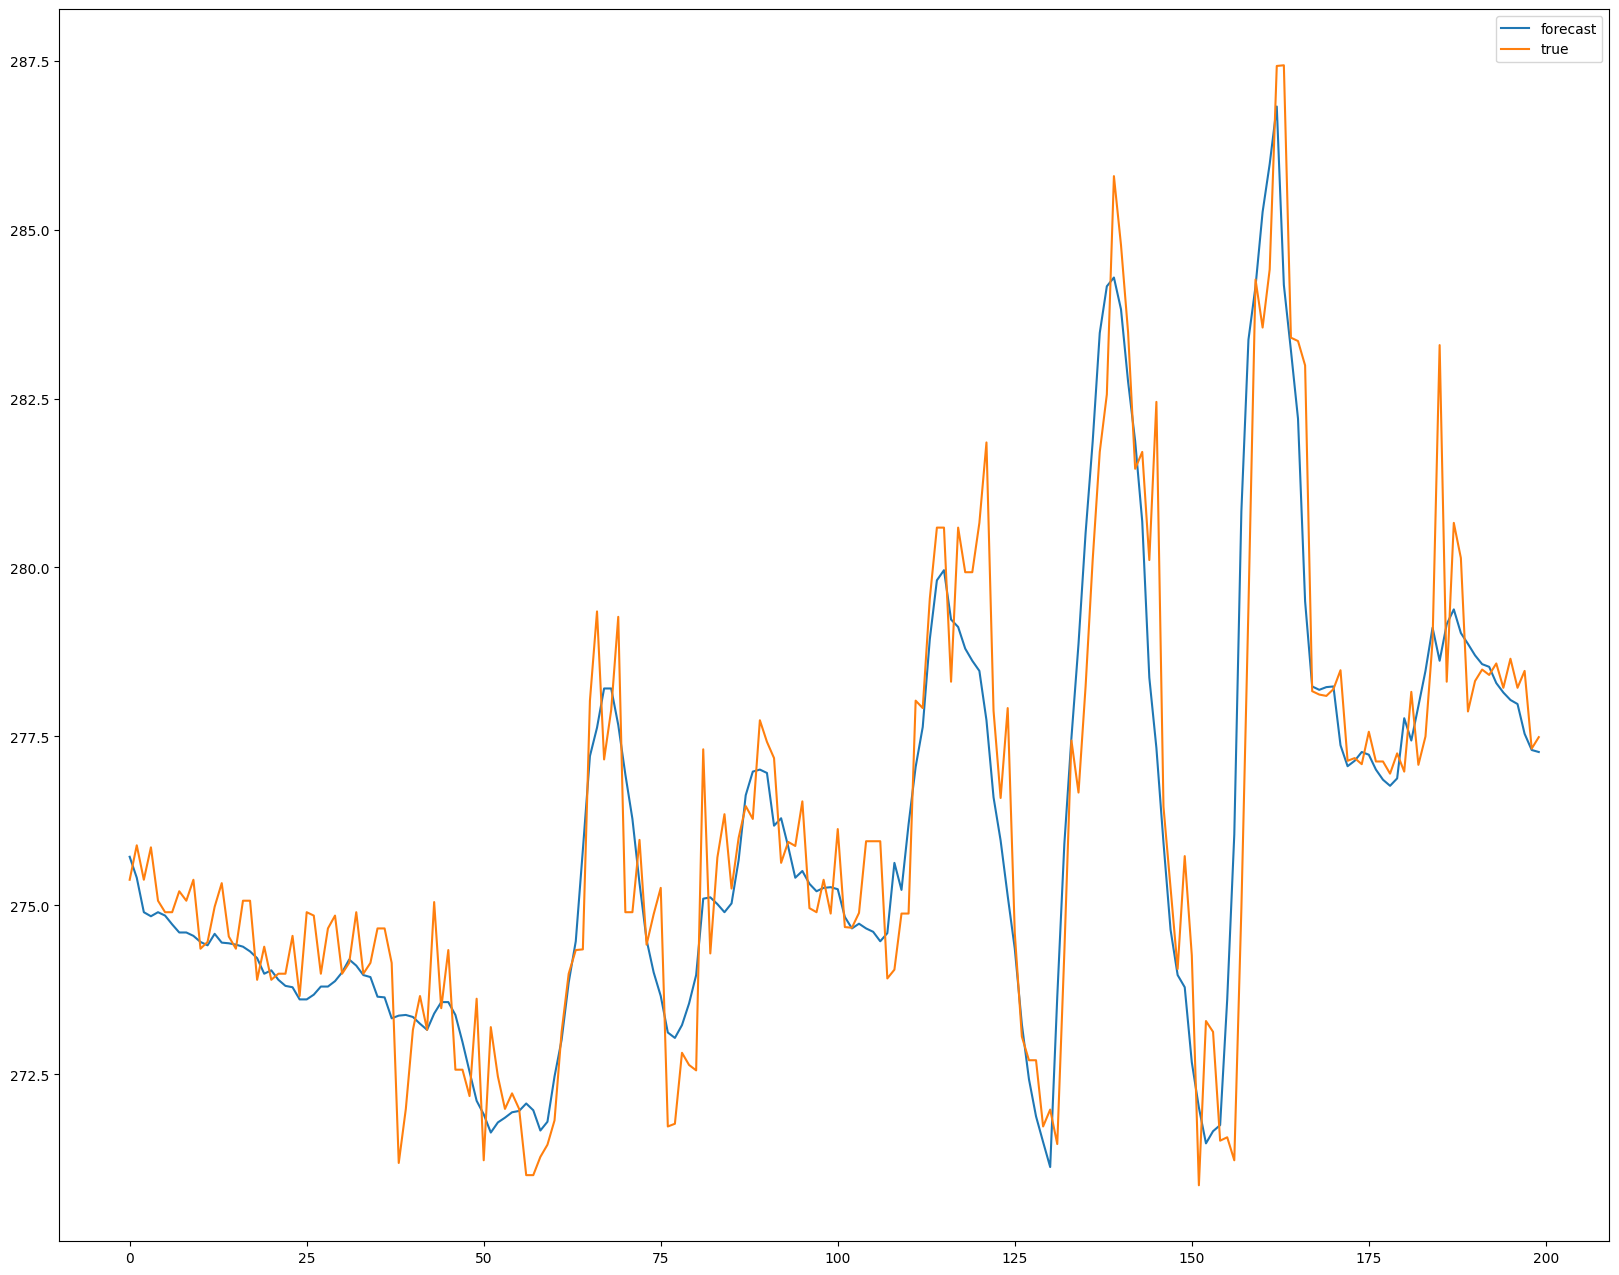

MSE: 2.130137962037962
RMSE: 1.4594992161827158
MAE: 1.081317254174397
Analyzing predictions for Tdew (degC)


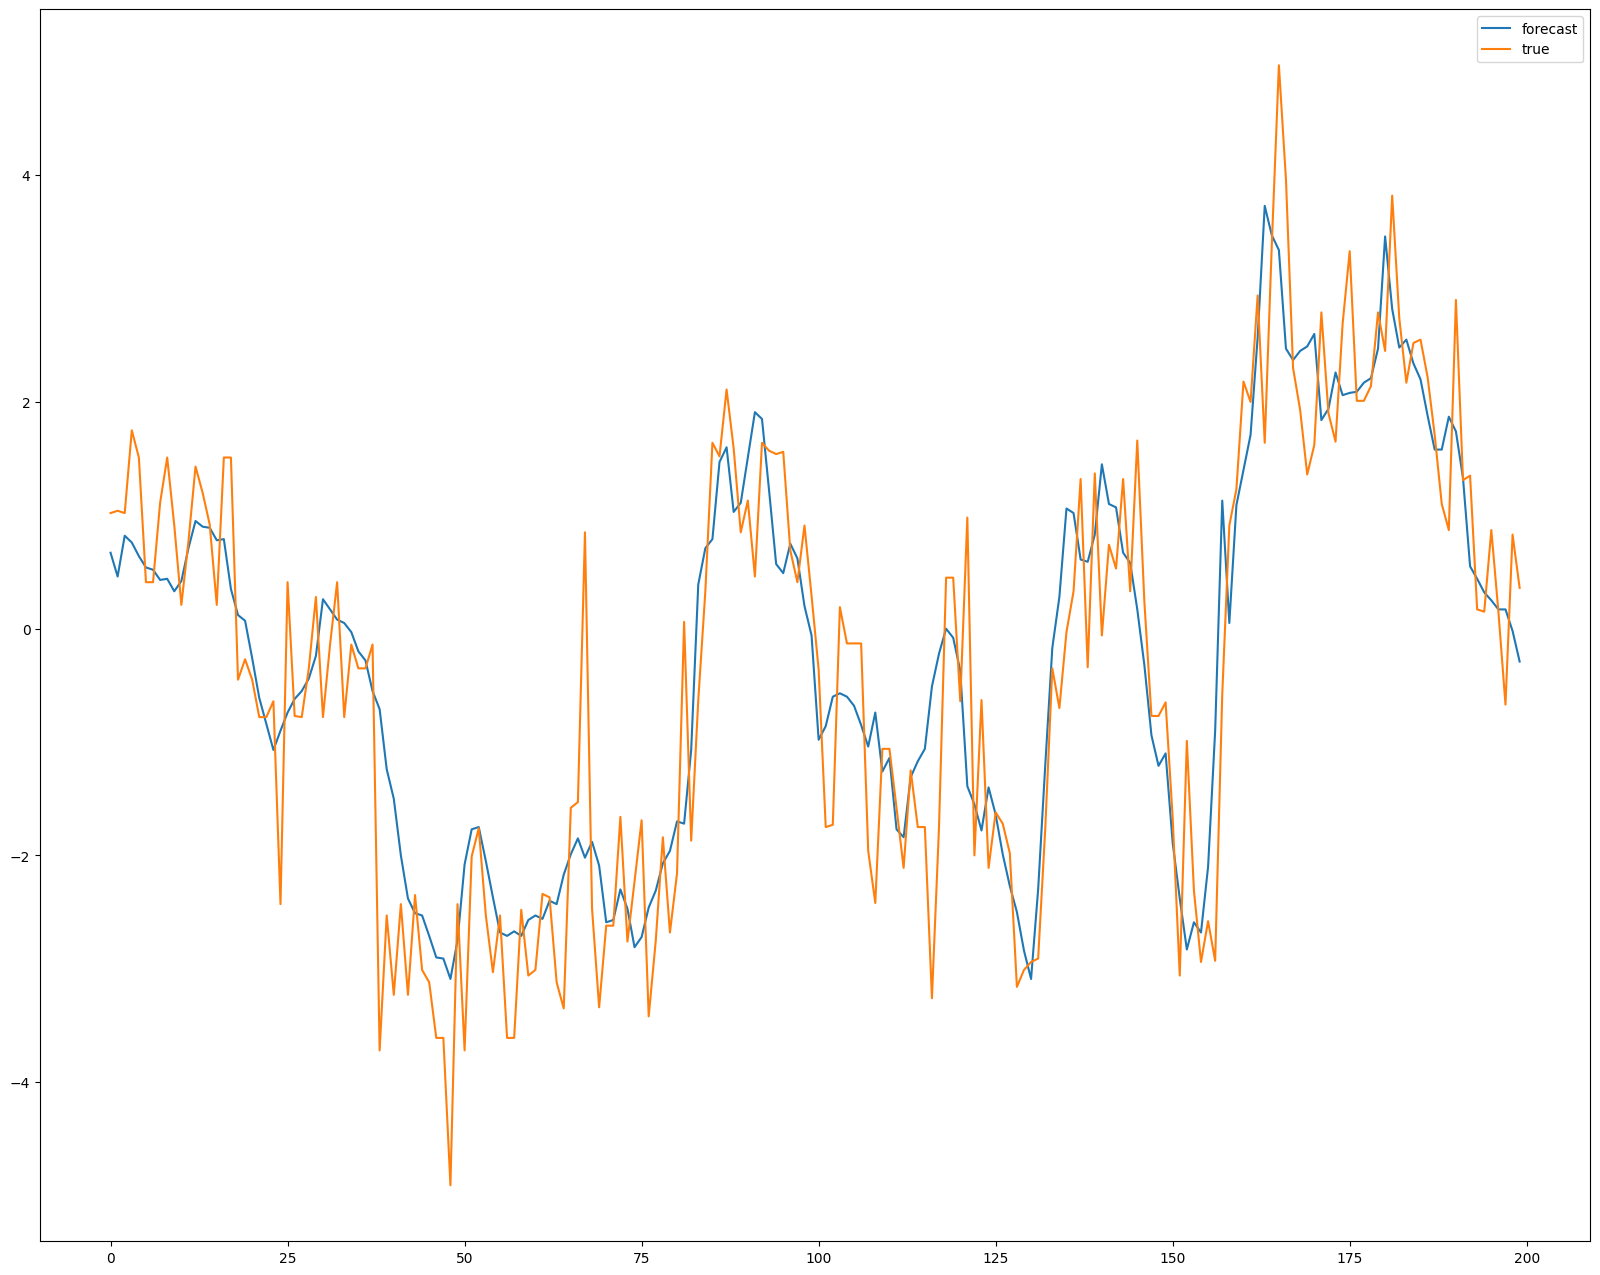

MSE: 0.9504097188525761
RMSE: 0.9748895931604645
MAE: 0.7297973455116313
Analyzing predictions for rh (%)


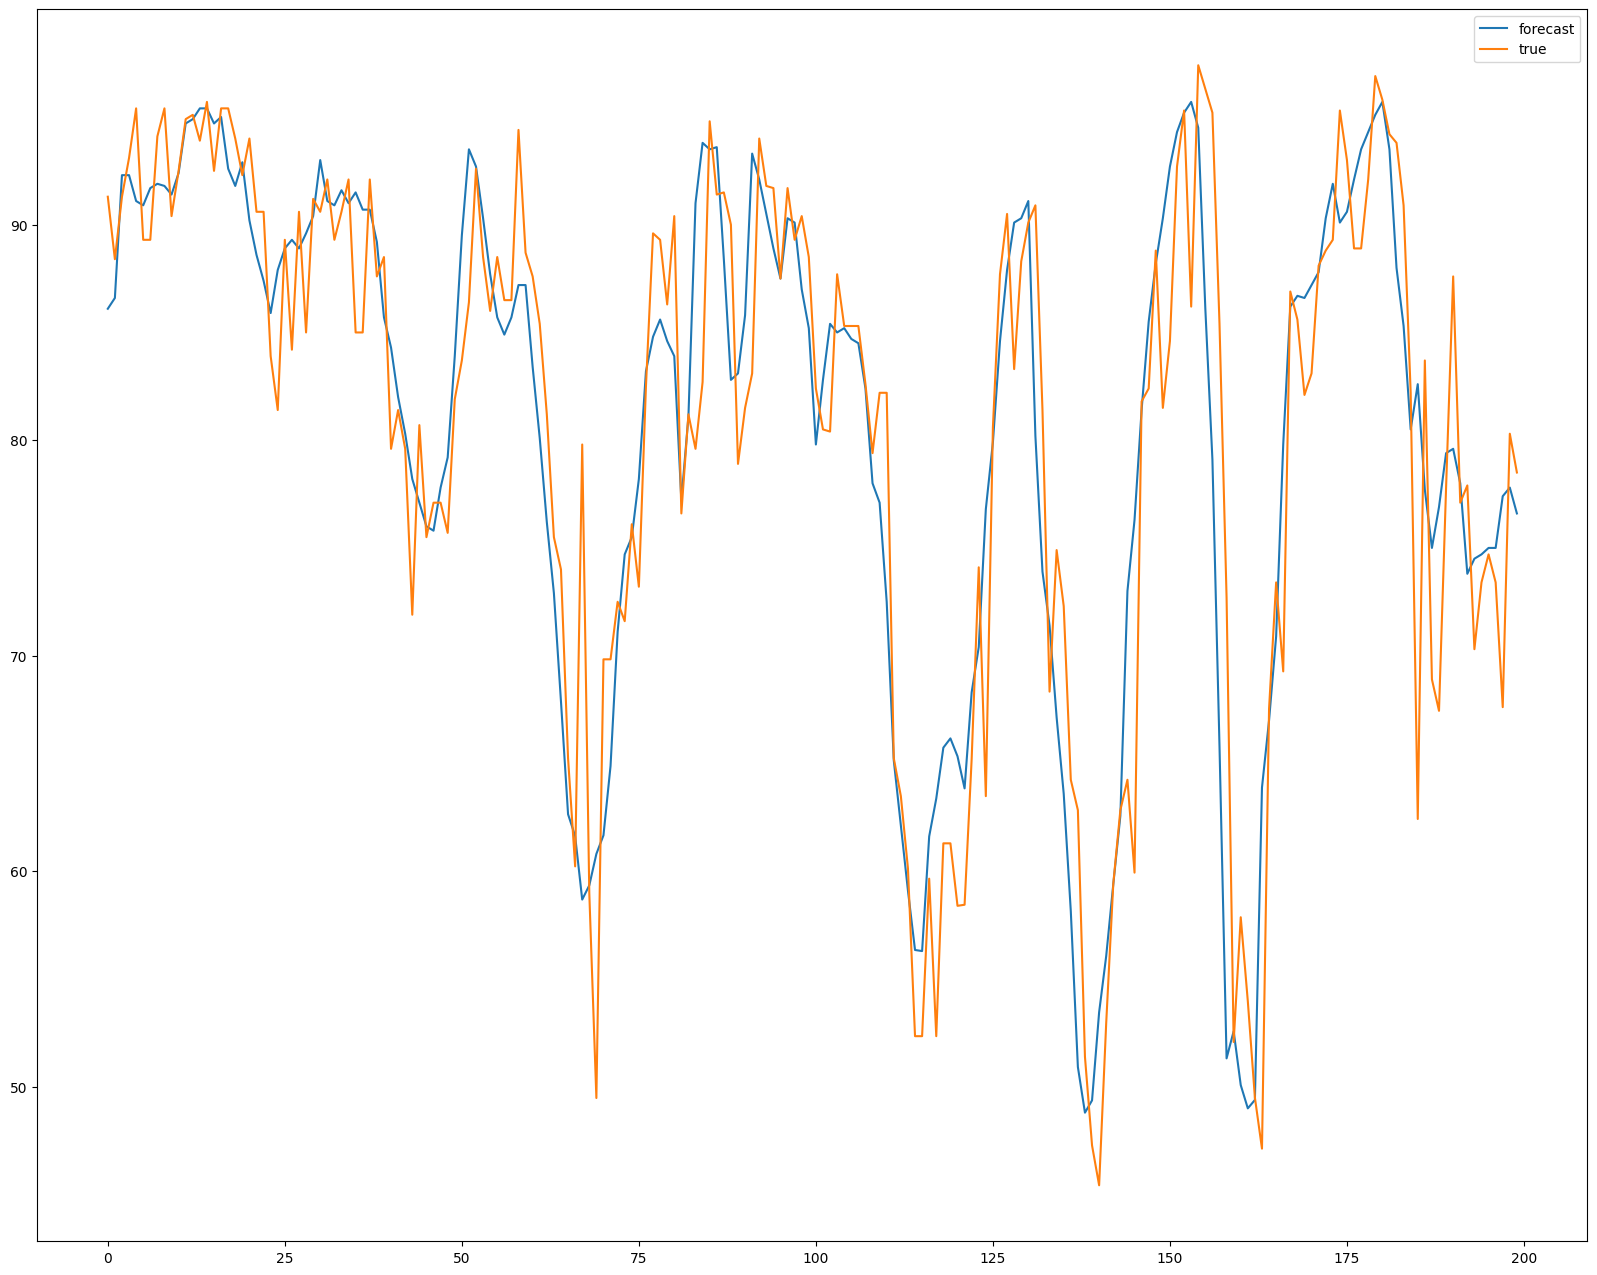

MSE: 40.842868816897386
RMSE: 6.390842574879887
MAE: 4.603896103896104
Analyzing predictions for VPmax (mbar)


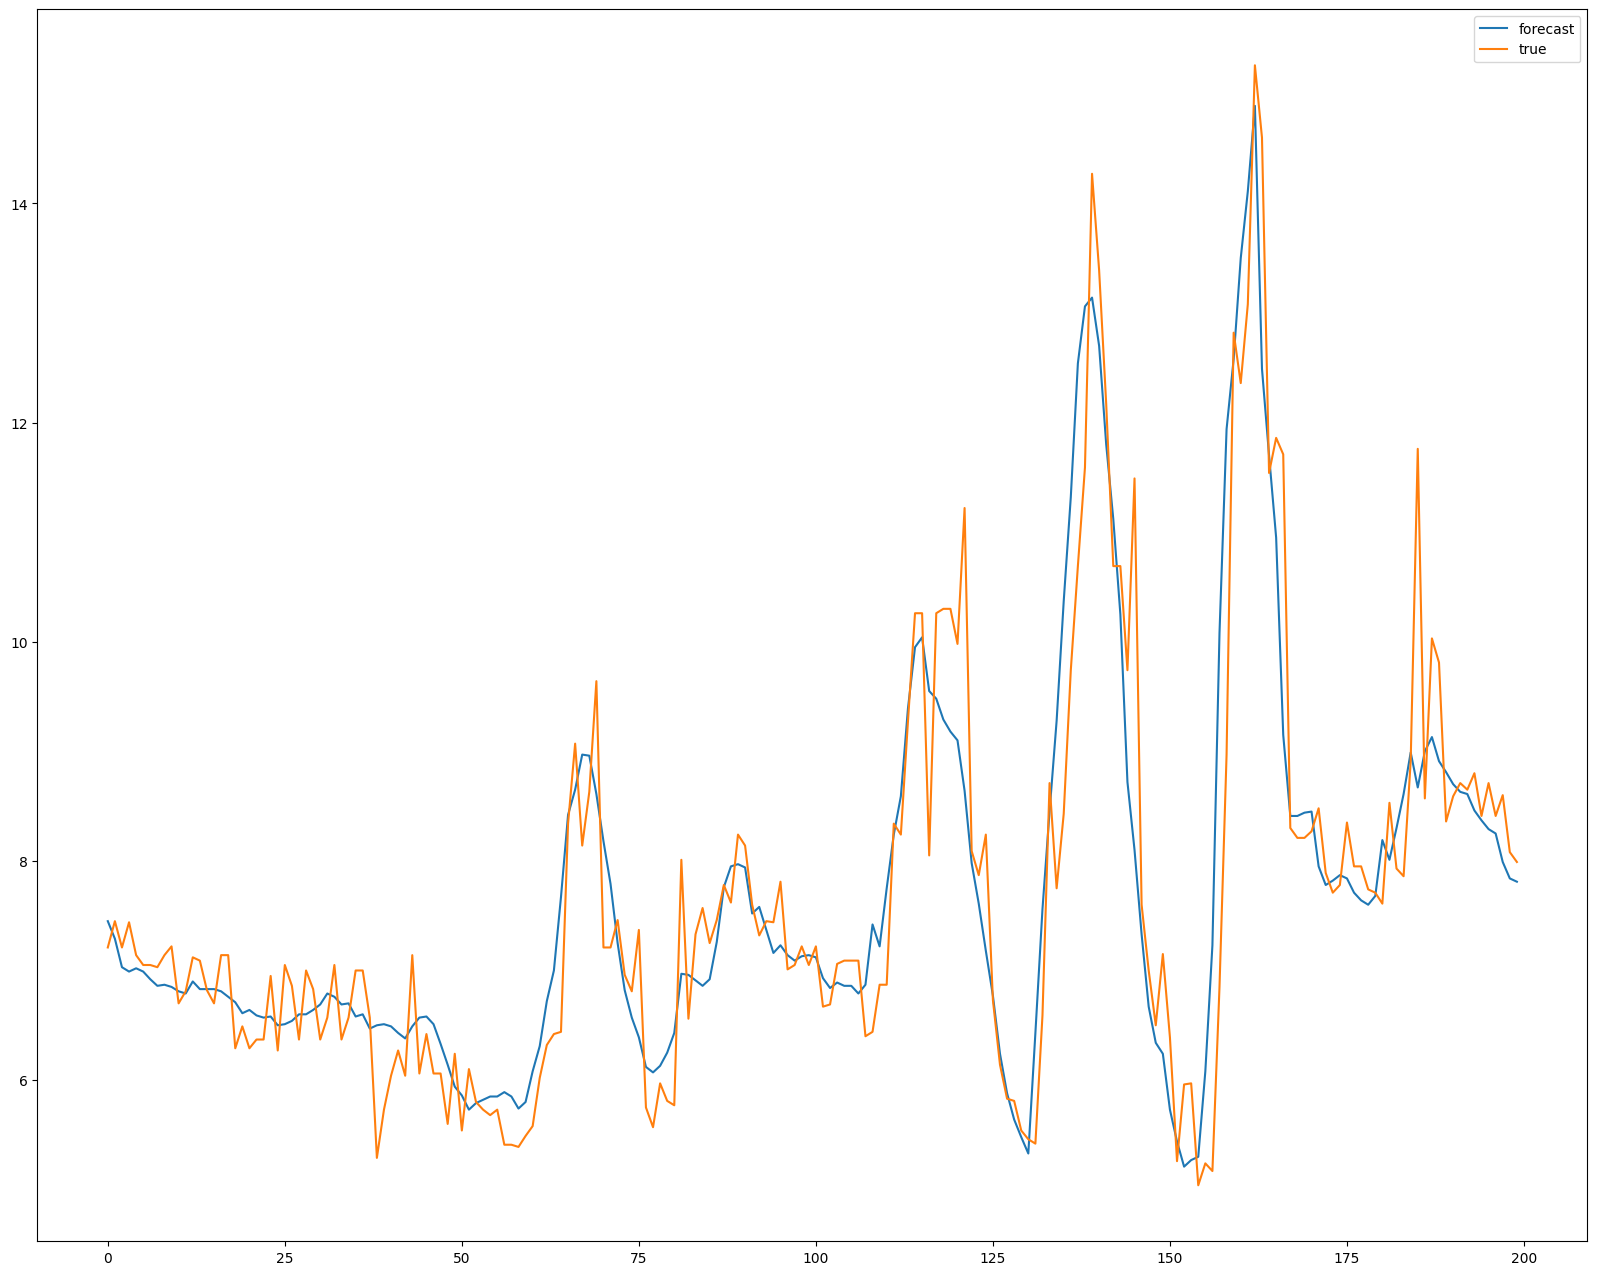

MSE: 3.0661100613672048
RMSE: 1.7510311423179215
MAE: 1.1528785500214072
Analyzing predictions for VPact (mbar)


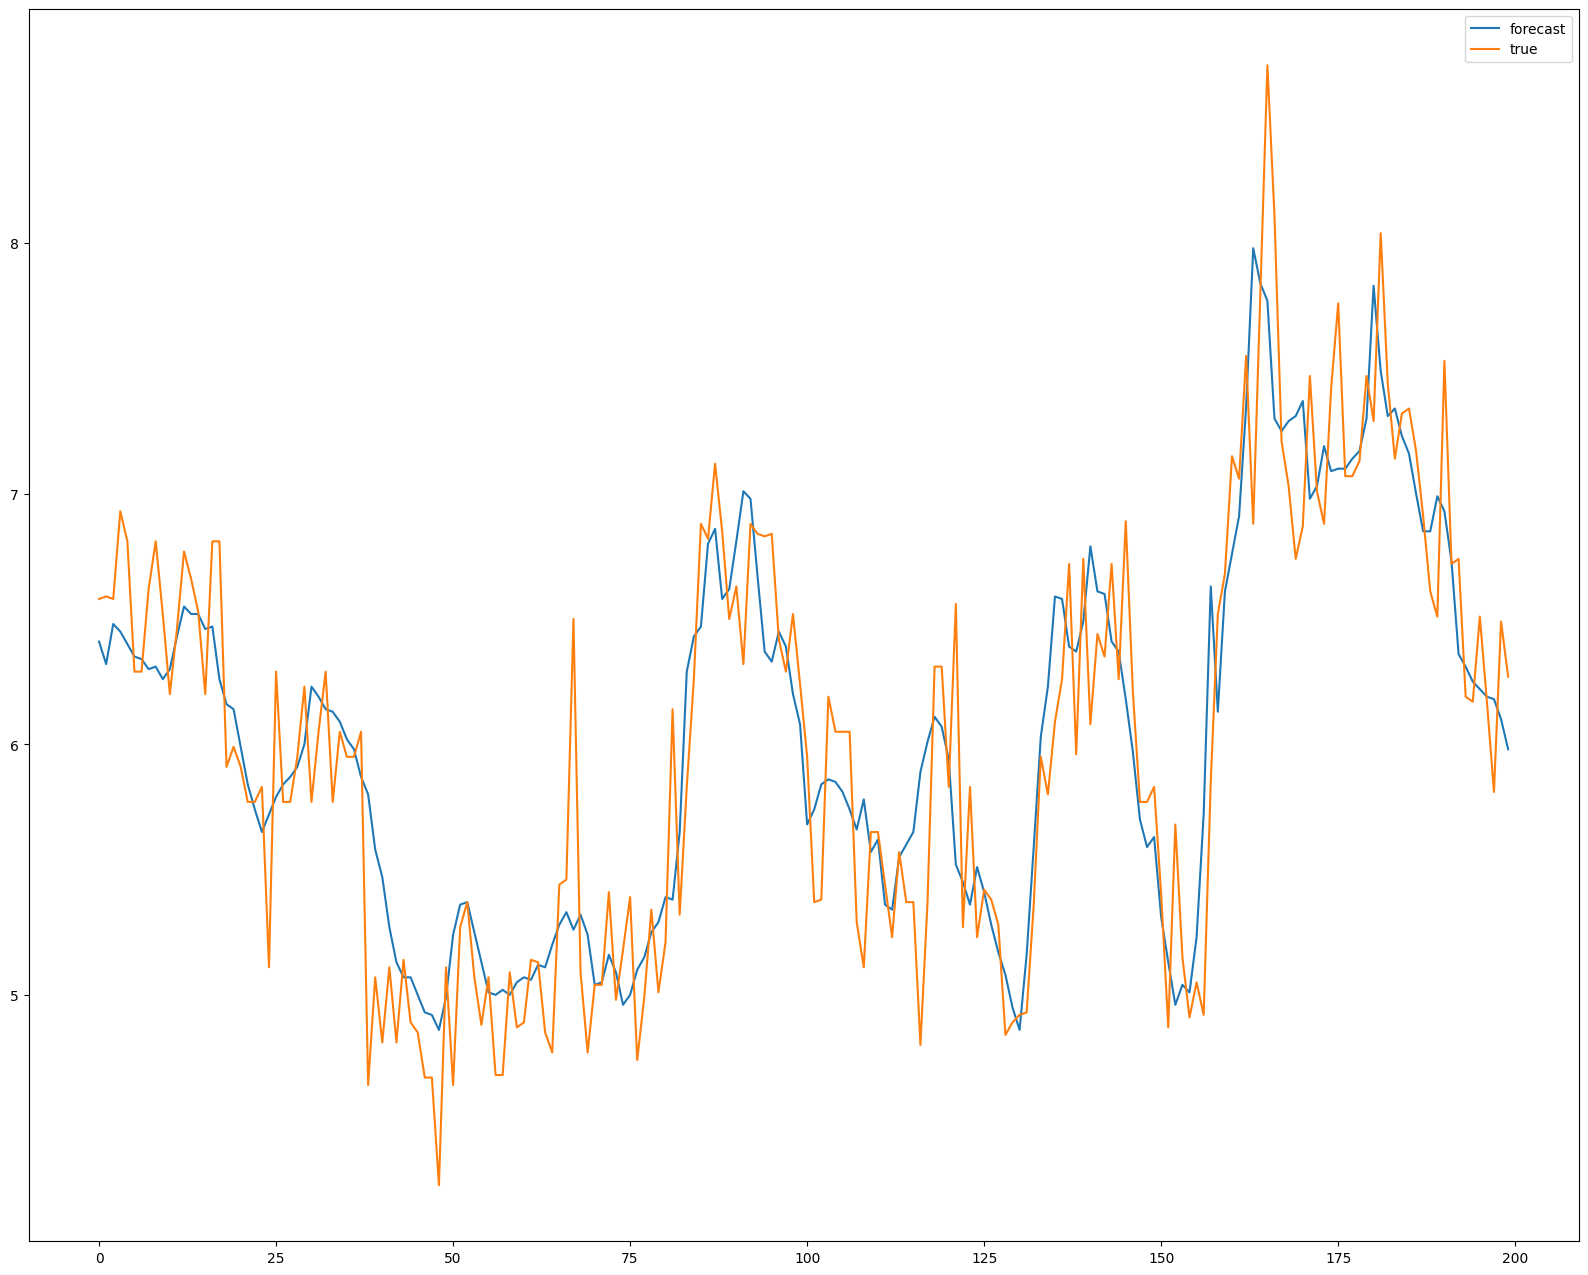

MSE: 0.5773625231910946
RMSE: 0.7598437491952504
MAE: 0.5327015841301556
Analyzing predictions for VPdef (mbar)


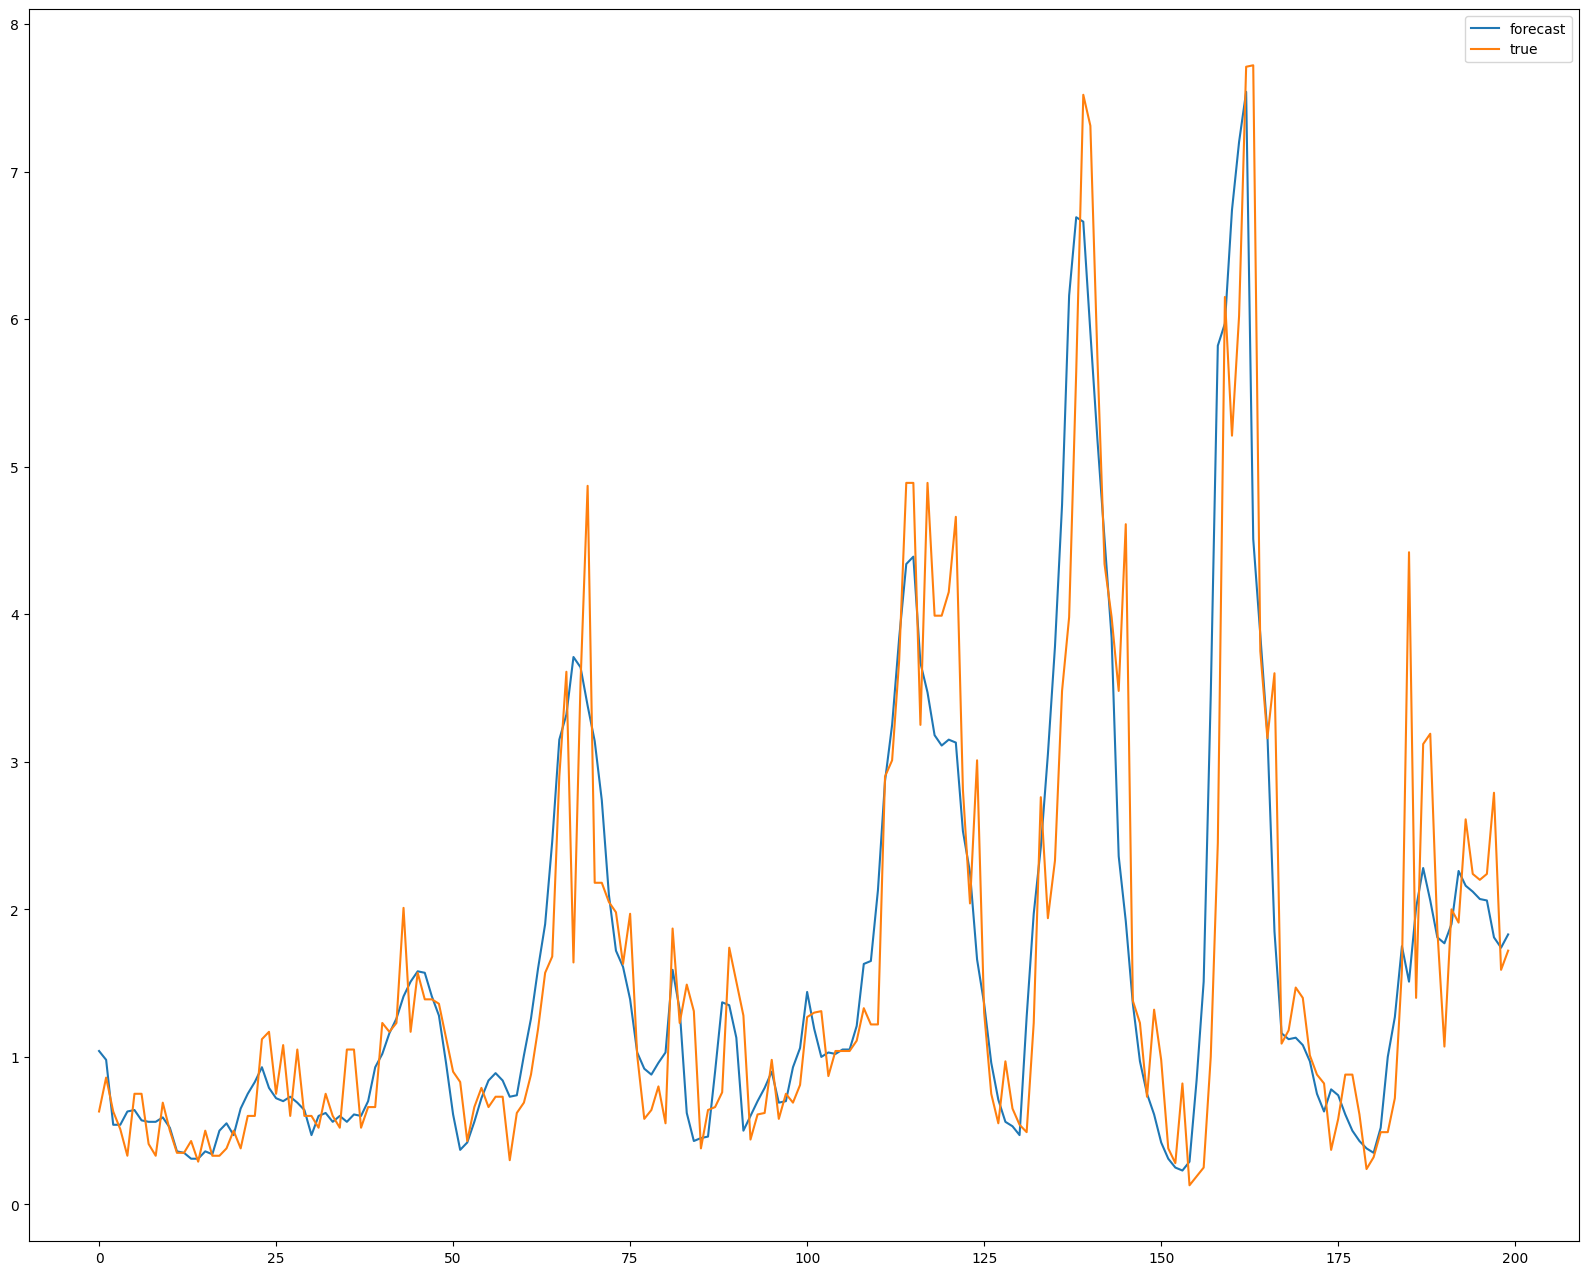

MSE: 3.0835352219209358
RMSE: 1.7559997784512775
MAE: 1.0875881261595548
Analyzing predictions for sh (g/kg)


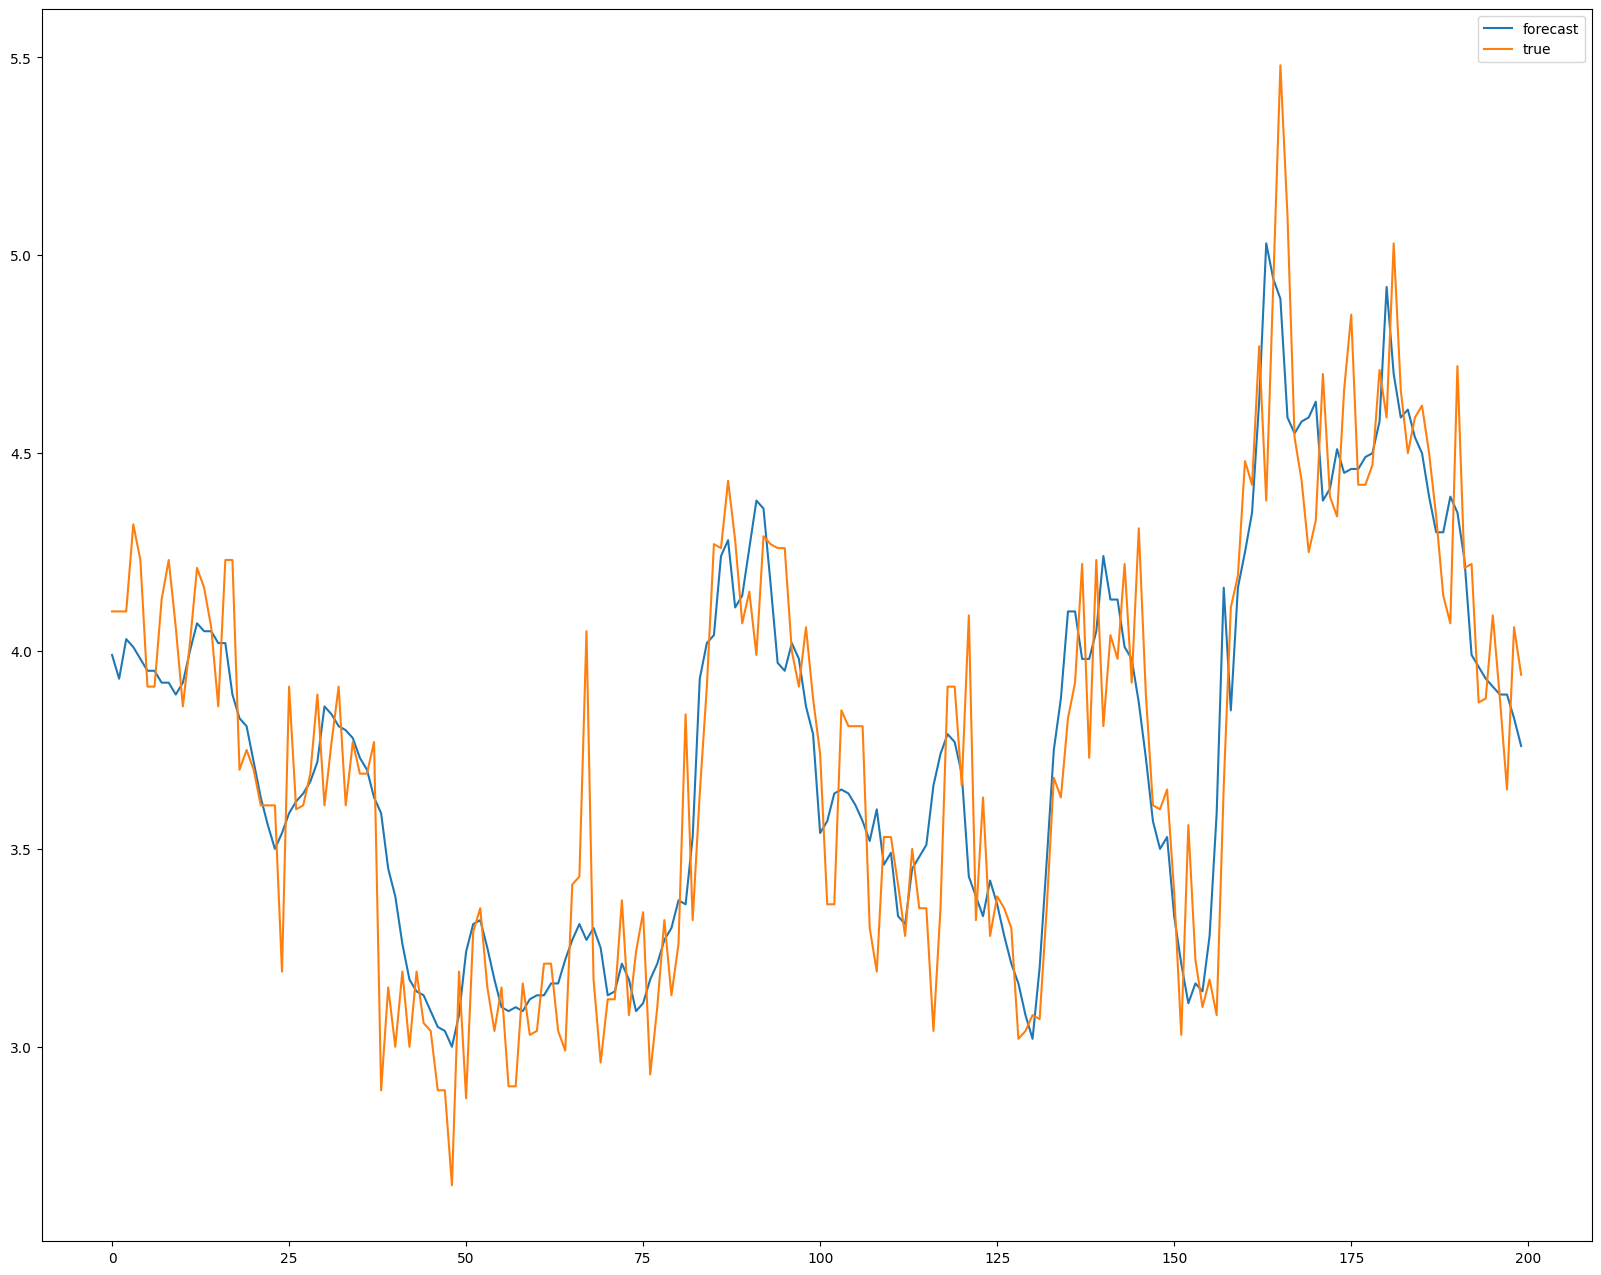

MSE: 0.22801429998572853
RMSE: 0.47750842923002784
MAE: 0.33300699300699305
Analyzing predictions for H2OC (mmol/mol)


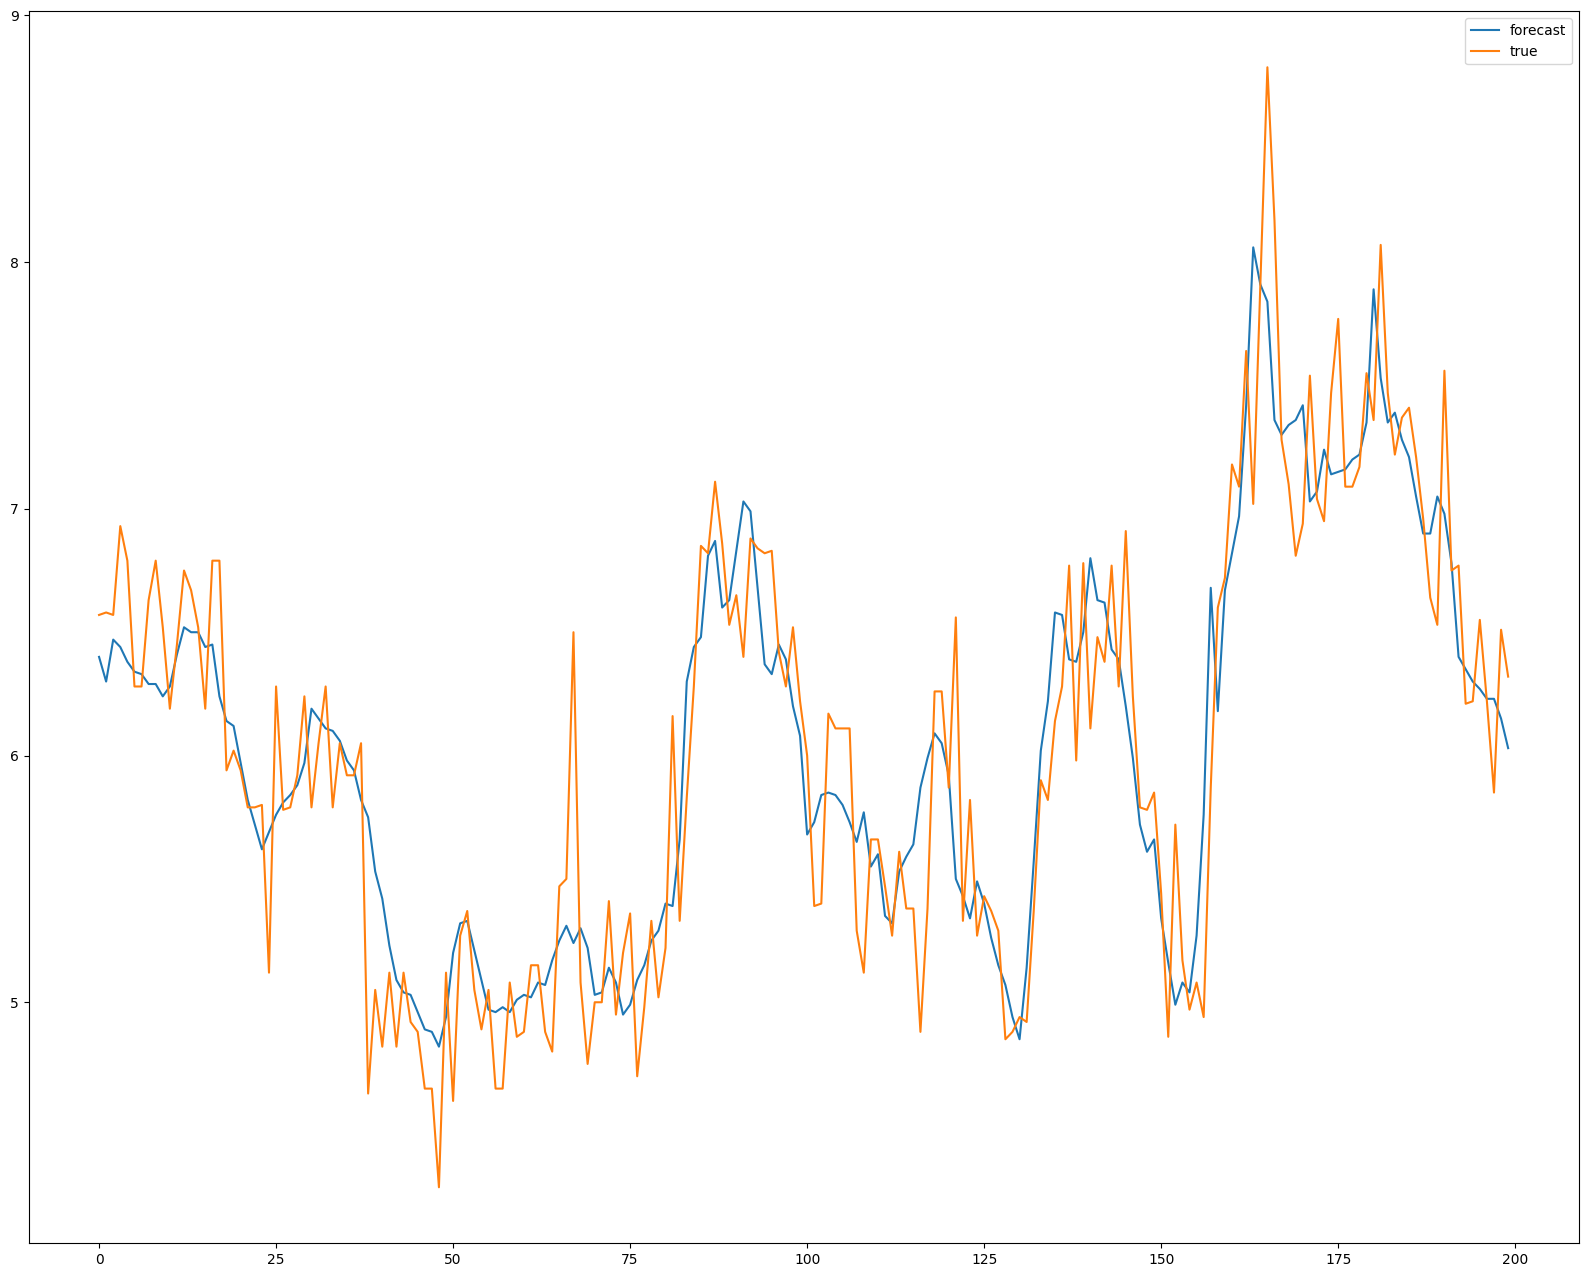

MSE: 0.5772567575281861
RMSE: 0.7597741490260024
MAE: 0.5304652490366776
Analyzing predictions for rho (g/m**3)


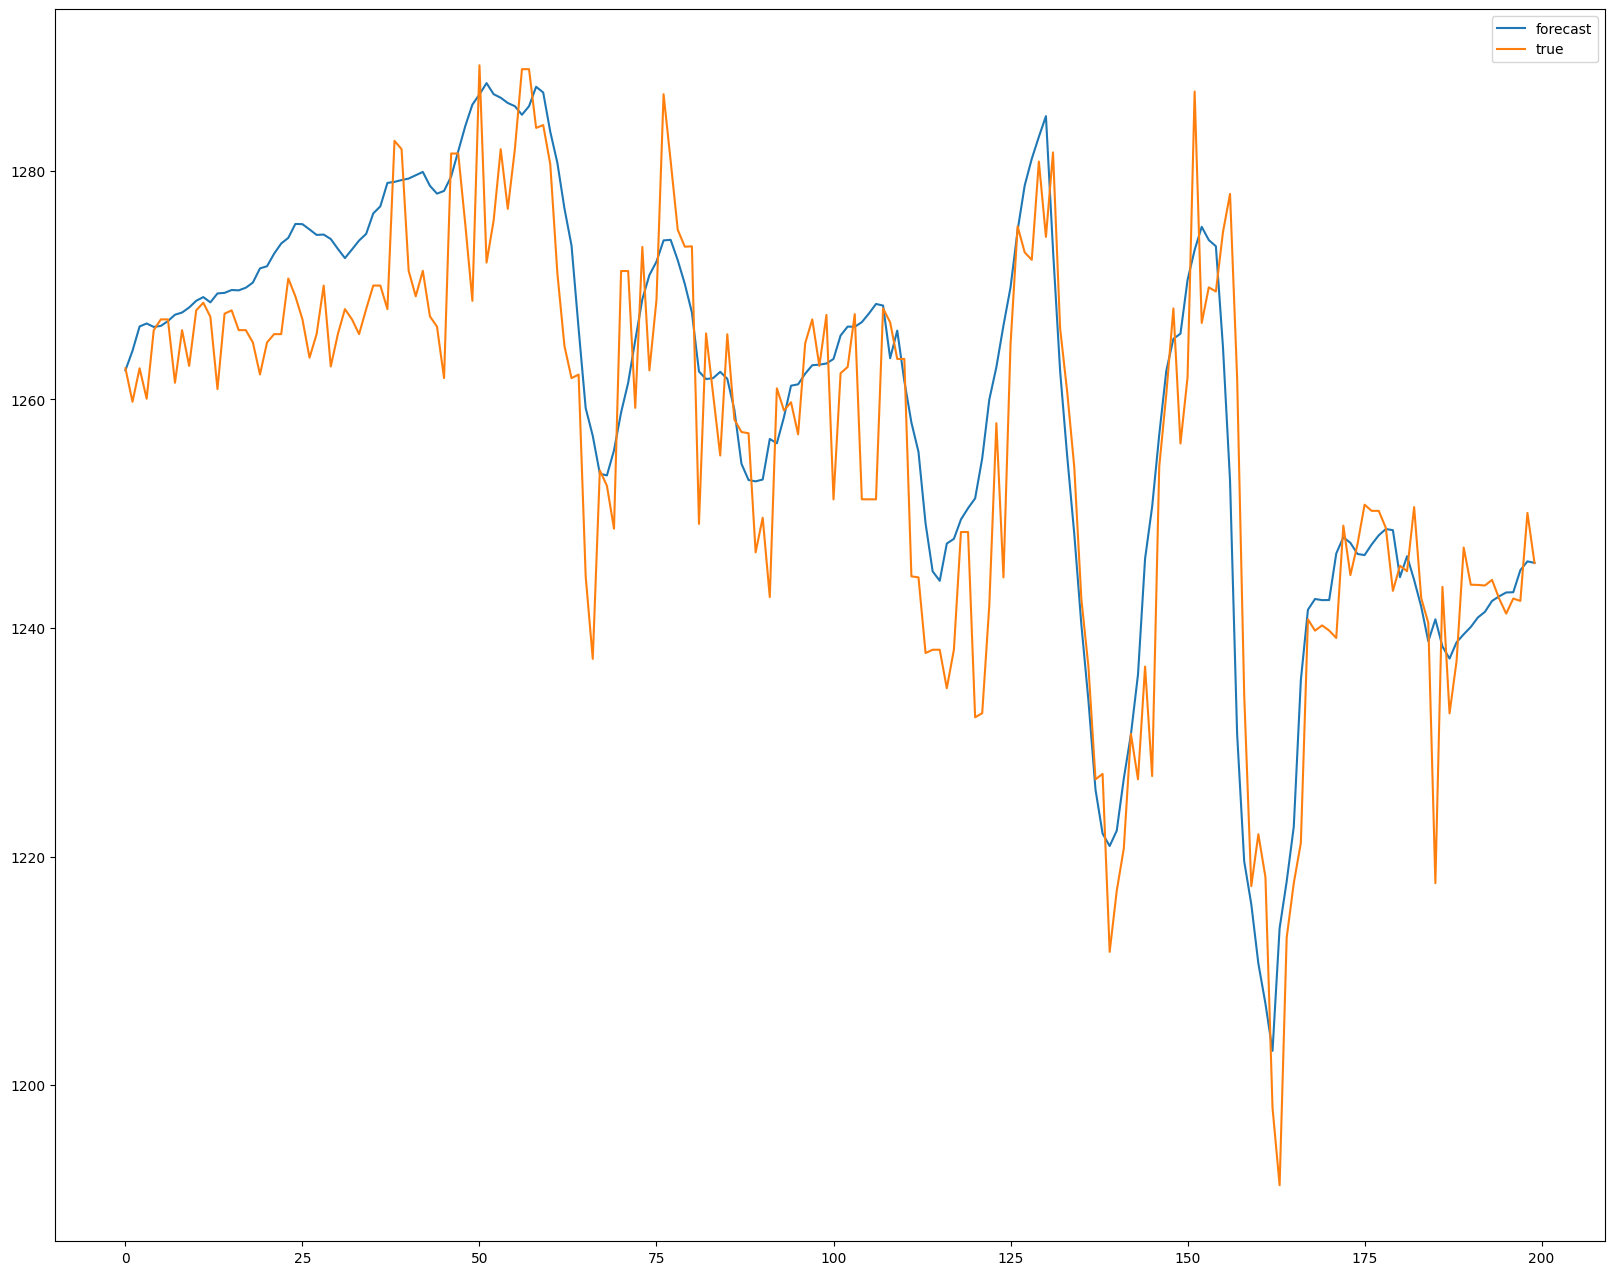

MSE: 61.230093178250335
RMSE: 7.824966017705785
MAE: 6.068718424432712
Analyzing predictions for wv (m/s)


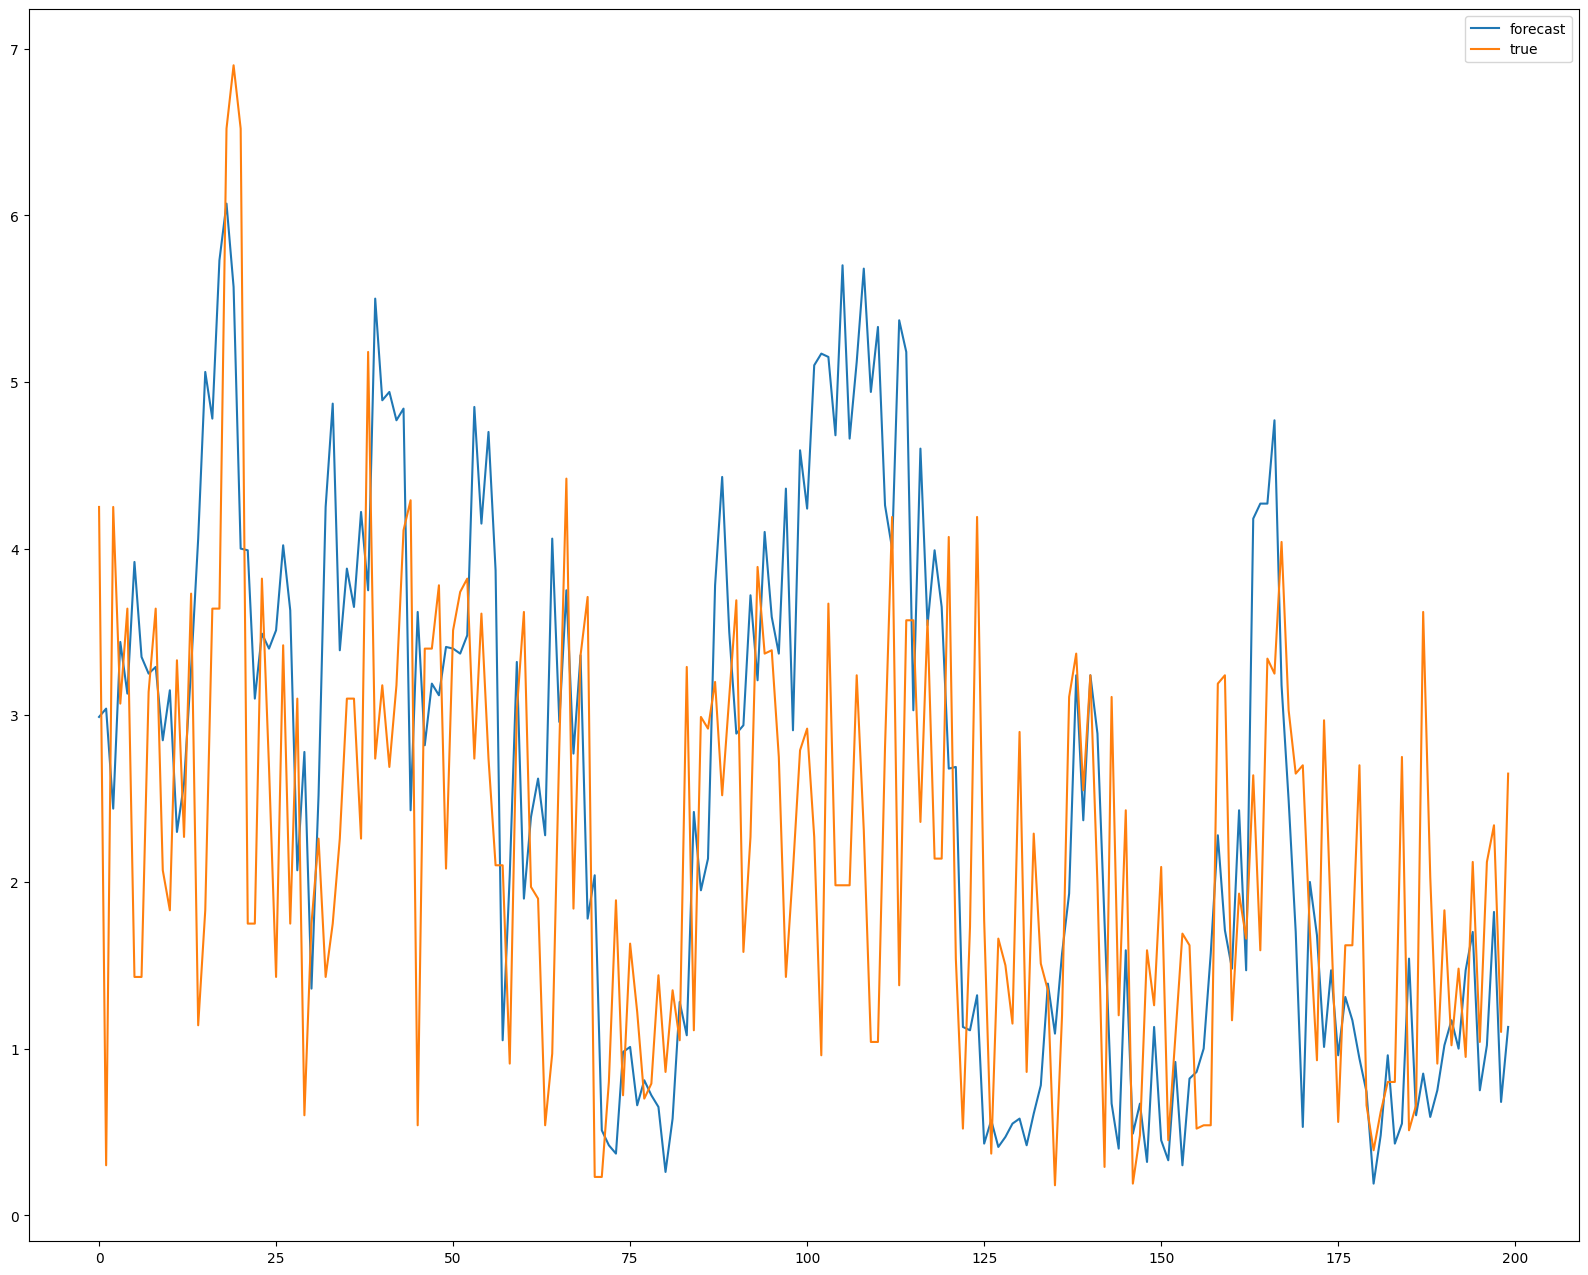

MSE: 1.6955255030683603
RMSE: 1.3021234592266435
MAE: 0.9633709147994862
Analyzing predictions for max. wv (m/s)


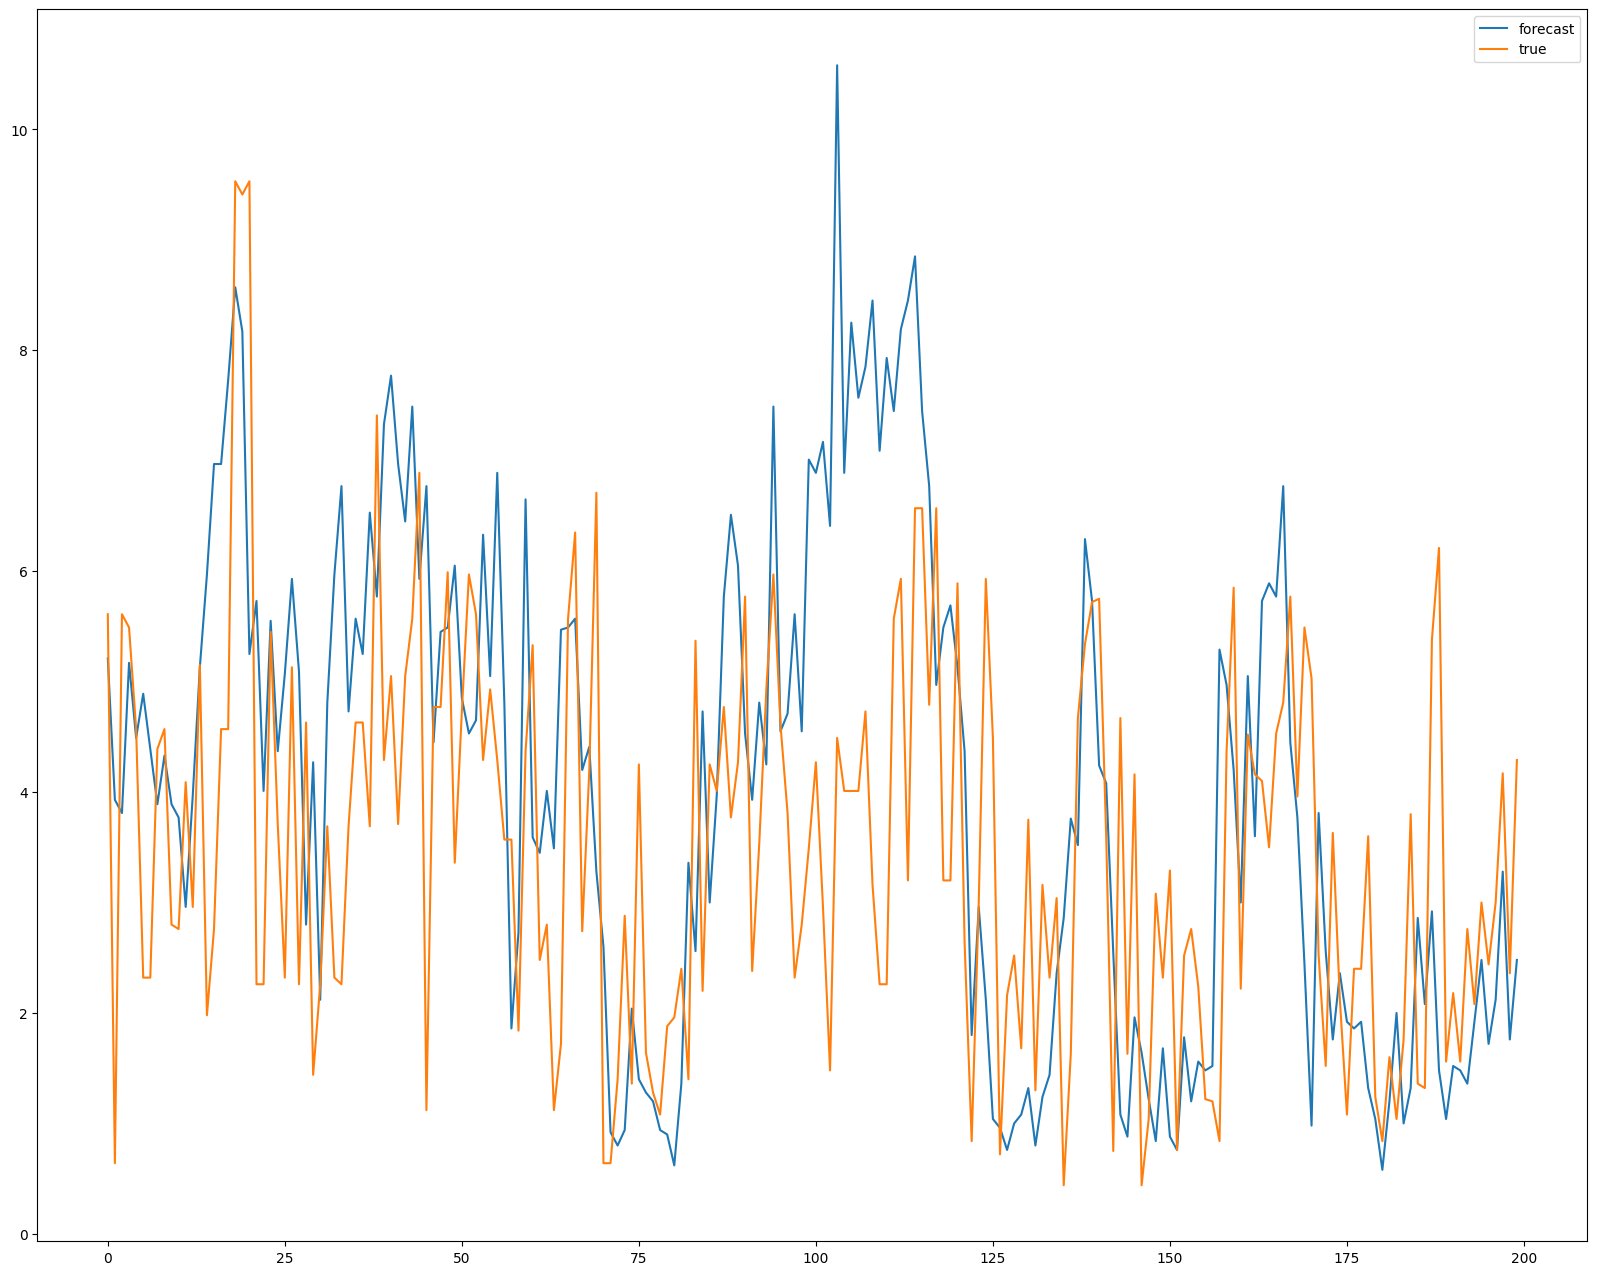

MSE: 3.997610518053375
RMSE: 1.9994025402738127
MAE: 1.4888240331097475
Analyzing predictions for wd (deg)


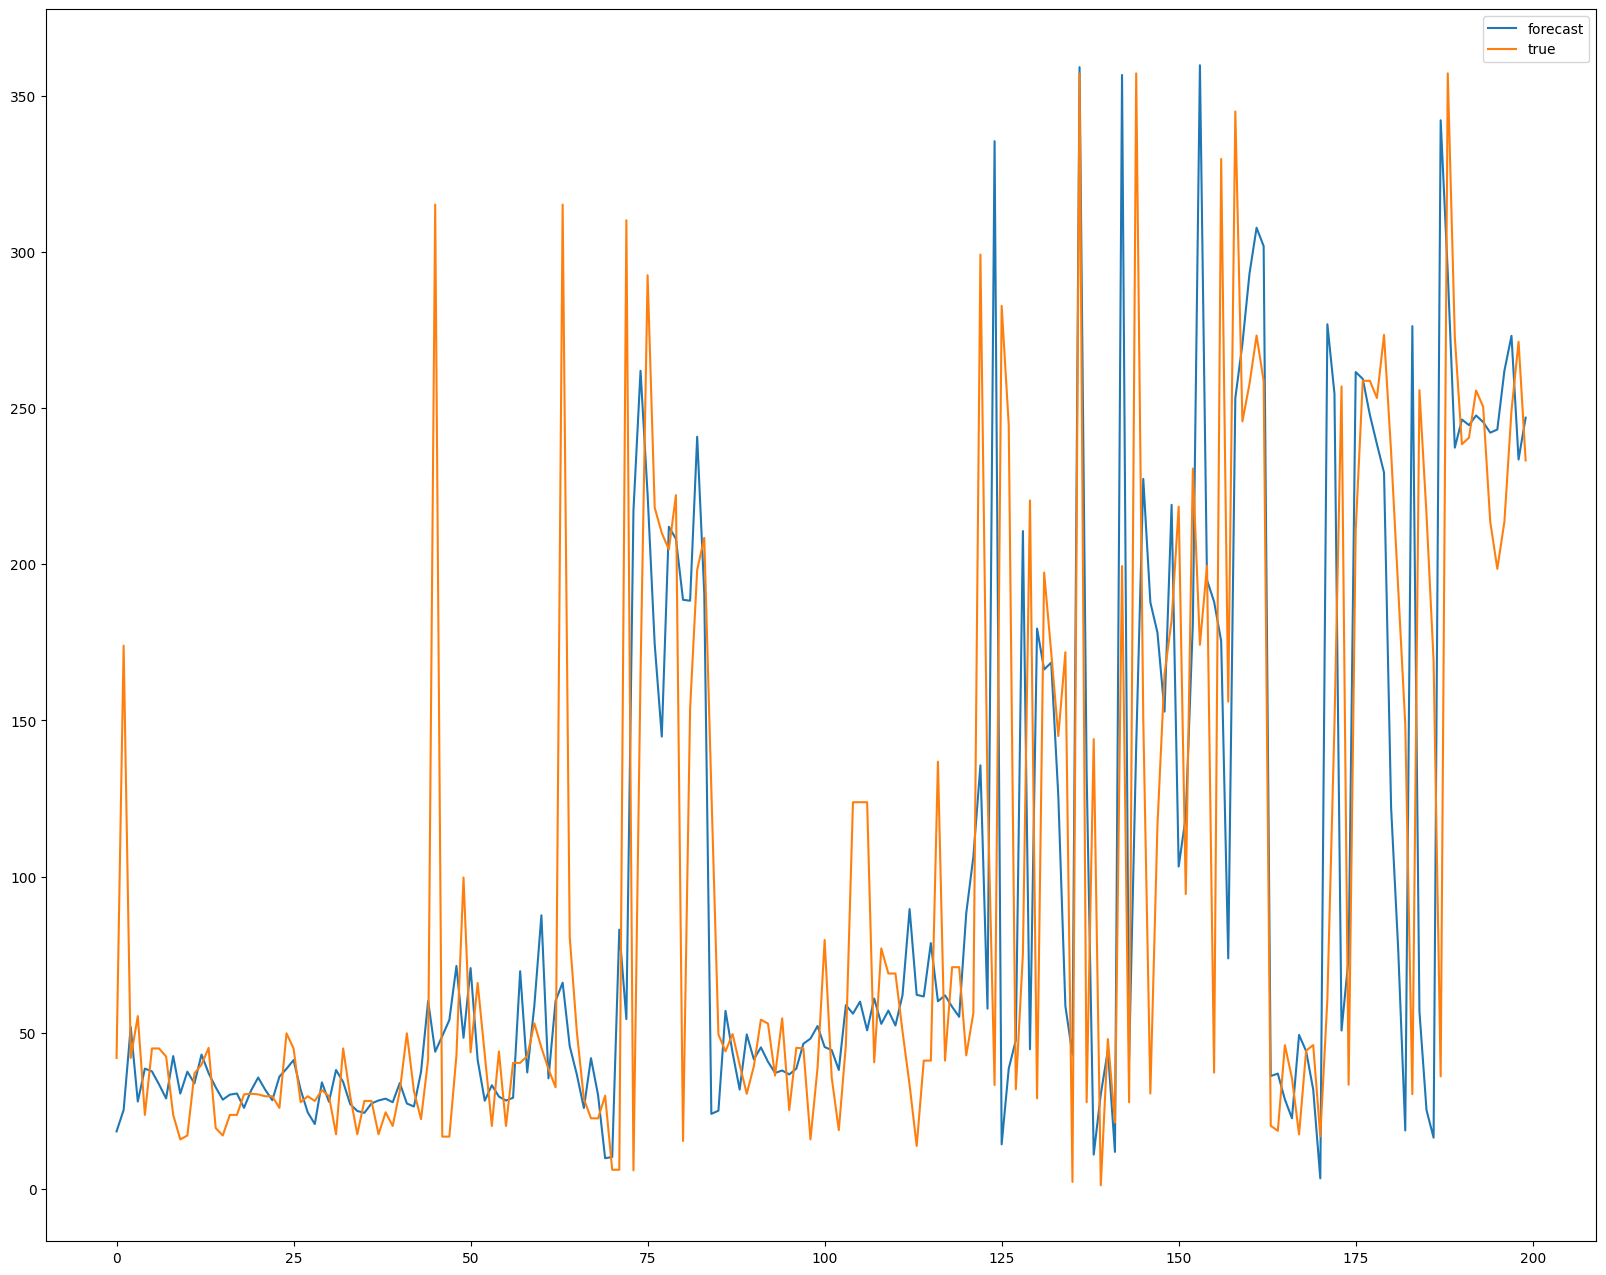

MSE: 9485.821956957328
RMSE: 97.39518446492788
MAE: 63.03478236049664


In [137]:
for feature in df.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)
    print_results(true_values, predicted_values)